### Importing the Libraries

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime

### Importing the dataset

In [11]:
def get_date_offset(dates):
    base_date = datetime.datetime.strptime('2021-01-01', "%Y-%m-%d")
    date_offsets = []
    for date_string in dates:
        date_object = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        offset_days = (date_object - base_date).days
        
        date_offsets.append(offset_days/365)

    return np.array(date_offsets)

In [12]:
df = pd.read_csv('data_daily.csv')

X = get_date_offset(df['# Date']).reshape(-1, 1)
X = np.hstack((X, [[1] for _ in range(df.shape[0])]))
y = df['Receipt_Count'].to_numpy().reshape(-1,1)

From the visualization, it is clear that there is a linear relationship between the dates and the number of receipts scanned. So we should create a Linear regression model of type 

$$
y = Ax + B
$$

where y is the number of scanned receipts and x is the number of days from 1 January 2021. A and B are co-efficients learned by the model.

In [13]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, dtype=torch.double)  # Input dimension is 1, output dimension is 1

    def forward(self, x):
        return self.linear(x)

    def train(self, x_train, y_train, num_epochs=1000, learning_rate=0.01):
        criterion = nn.MSELoss()  # Mean Squared Error loss
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer

        for epoch in range(num_epochs):
            # x_train = x_train.double()
            # y_train = y_train.double()
            # Forward pass
            outputs = self(x_train)
            loss = criterion(outputs, y_train)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100000 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    def test(self, x_test):
        with torch.no_grad():
            return self(x_test)

### Training the data set

After tuning the hyper parameters, learning rate of $10^{-5}$ generates the best fit.

In [14]:
X = torch.tensor(X, dtype = torch.double)

y = torch.tensor(y, dtype=torch.double)

torch.manual_seed(0)

# Initialize and fit the linear regression model
model = LinearRegression(2, 1)
model.train(X, y, num_epochs=1000000, learning_rate=0.00001)

Epoch [100000/1000000], Loss: 76839516906.2646
Epoch [200000/1000000], Loss: 62249653054.5508
Epoch [300000/1000000], Loss: 58361335465.8239
Epoch [400000/1000000], Loss: 55467840523.3511
Epoch [500000/1000000], Loss: 53314024244.0943
Epoch [600000/1000000], Loss: 51710798777.6123
Epoch [700000/1000000], Loss: 50517413844.4797
Epoch [800000/1000000], Loss: 49629099862.1986
Epoch [900000/1000000], Loss: 48967870019.9178
Epoch [1000000/1000000], Loss: 48475673664.7504


### Plotting the Test data and the training data

The training data is given for the year 2021 and the model is to project the trend for the year 2022. So plotting the projection and the validate appropriate projection of the trend for the year 2022.

Predicted value: tensor(12527638.2628, dtype=torch.float64) tensor(10211187., dtype=torch.float64)


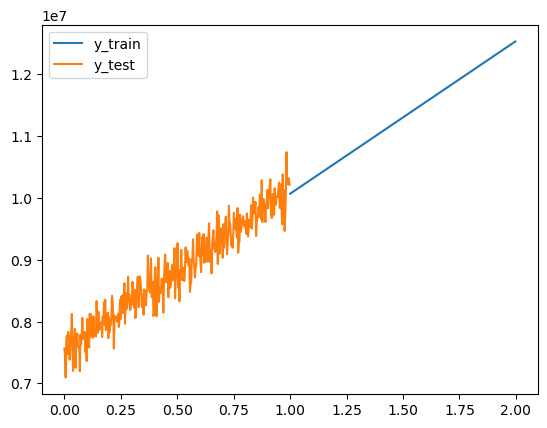

In [15]:
x_test = np.array([x+1 for x in X[:,0]]).reshape(-1, 1)
X_test = np.hstack((x_test, [[1] for _ in range(df.shape[0])]))
X_test = torch.tensor(X_test, dtype = torch.double)
y_pred = model.test(X_test)
print("Predicted value:", y_pred[-1][0], y[-1][0])
plt.plot(X_test[:, 0], y_pred)
plt.plot(X[:, 0], y)
plt.legend(["y_train", "y_test"])

### Saving the model
Now that the model is a good match, we save the model to be used by our application

In [16]:
traced_model = torch.jit.trace(model, X)
traced_model.save("linear_regression_model.pt")